In [5]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, mean_squared_error, ConfusionMatrixDisplay

from task3_1 import preprocess_star_dataset, preprocess_gwp_dataset

## Star Dataset

In [12]:
def evaluate_classification_model(model, x_test, y_test, plot=True):
    y_pred = model.predict(x_test)
    print(f'Accuracy: {model.score(x_test, y_test)}')
    print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1-score: {f1_score(y_test, y_pred, average="weighted")}')
    if plot:
        ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['GALAXY', 'QSO', 'STAR'], cmap=plt.cm.Blues)

In [3]:
star_X, star_Y = preprocess_star_dataset('datasets/star_assessment.csv')

#### Train an SVM classifier using the holdout method

First let's split the dataset into training and test sets

In [8]:
star_x_train, star_x_test, star_y_train, star_y_test = train_test_split(star_X, star_Y, test_size=0.2, stratify=star_Y)

Then we can train a Support Vector Machine classifier using the training set and evaluate it using the test set

Accuracy: 0.9651346142615196
Precision: 0.9650226399762944
Recall: 0.9651346142615196
F1-score: 0.9645091514849647


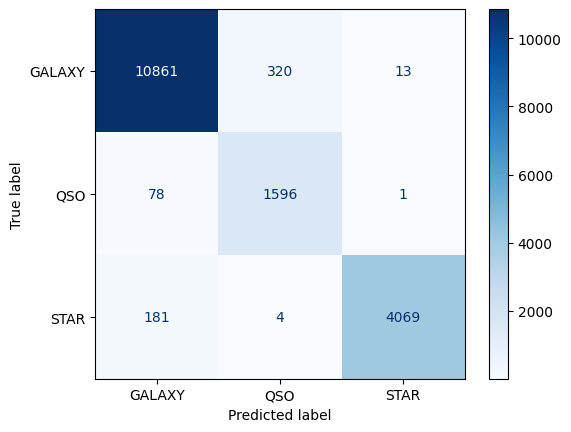

In [13]:
svc_holdout = SVC()
svc_holdout.fit(star_x_train, star_y_train)
evaluate_classification_model(svc_holdout, star_x_test, star_y_test)

#### Train an SVM classifier using cross-validation

Next, we can train an SVM classifier using cross-validation to get a better estimate of the model's performance, and calculate the mean accuracy and standard deviation of the model's performance across the folds

In [16]:
svc_cv = SVC()
svc_cv_scores = cross_val_score(svc_cv, star_X, star_Y, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {svc_cv_scores.mean()}')
print(f'Standard deviation: {svc_cv_scores.std()}')

Mean accuracy: 0.9644096152996191
Standard deviation: 0.0008522282547938581


#### Perform SVM hyperparameter tuning

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3],
    'gamma': ['scale', 'auto', 0.1, 1, 10, 100]
}

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(star_X, star_Y)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


In [9]:
grid_search.best_params_

## GWP Dataset

In [14]:
def plot_actual_predicted(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(y_test[:10], 'o', label='Actual')
    ax.plot(y_pred[:10], 'o', label='Prediction')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.xlabel('Index of sample')
    plt.ylabel('Actual/Predicted value of the target')
    plt.show()

In [15]:
def evaluate_regression_model(model, x_test, y_test, plot=True):
    y_pred = model.predict(x_test)
    print(f'R^2 Score: {r2_score(y_test, y_pred)}')
    print(f'MSE: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
    if plot:
        plot_actual_predicted(y_test, y_pred)

In [16]:
gwp_X, gwp_Y = preprocess_gwp_dataset('datasets/gwp_assessment.csv')

#### Train an SVM regressor using the holdout method

First let's split the dataset into training and test sets

In [17]:
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = train_test_split(gwp_X, gwp_Y, test_size=0.2)

Then we can train a Support Vector Machine regressor using the training set and evaluate it using the test set

R^2 Score: 0.48545924951355746
MSE: 0.013106202274489963
RMSE: 0.11448232297822211


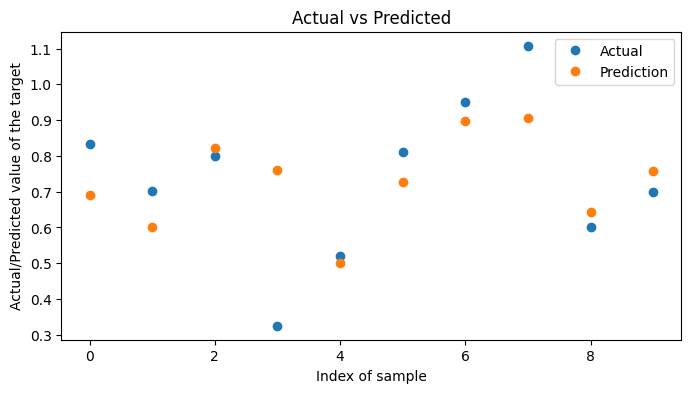

In [19]:
svr_holdout = SVR()
svr_holdout.fit(gwp_x_test, gwp_y_test)
evaluate_regression_model(svr_holdout, gwp_x_test, gwp_y_test)

#### Train an SVM regressor using cross-validation

Next, we can train an SVM regressor using cross-validation to get a better estimate of the model's performance, and calculate the mean R^2 score and standard deviation of the model's performance across the folds

In [33]:
svr_cv = SVR()
svr_cv_scores = cross_val_score(svr_cv, gwp_X, gwp_Y, scoring='r2', n_jobs=-1, cv=10)
print(f'Mean R^2 score: {svr_cv_scores.mean()}')
print(f'Standard deviation: {svr_cv_scores.std()}')

Mean R^2 score: 0.22528396392730948
Standard deviation: 0.1564210052984623


R^2 Score: 0.24961115277622314
RMSE: 0.14970664261963665


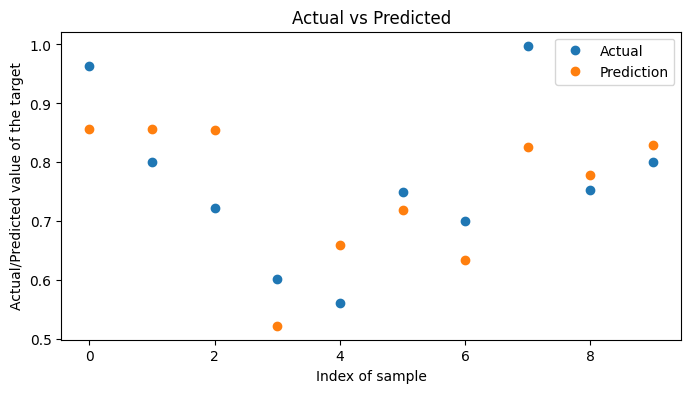

R^2 Score: 0.398744941280905
RMSE: 0.1340069297646259


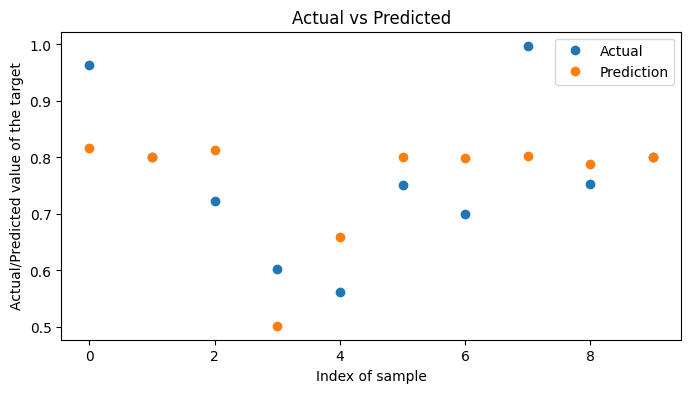

R^2 Score: 0.5628193182826295
RMSE: 0.11426898426595634


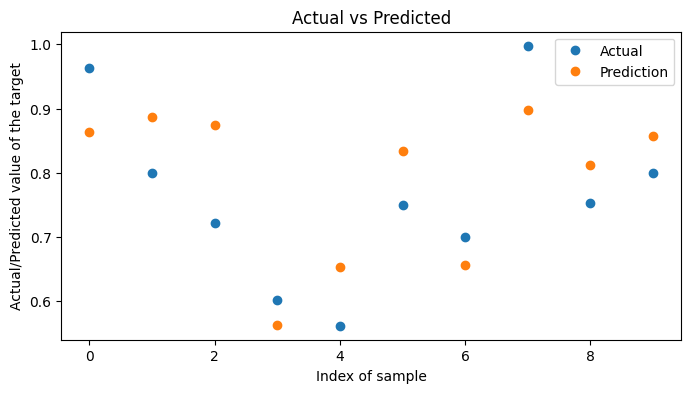

In [31]:
clf2 = SVR(kernel='linear')
clf2.fit(gwp_x_test, gwp_y_test)
evaluate_regression_model(clf2, gwp_x_test, gwp_y_test)

# Attempt 2
clf3 = SVR(kernel='poly', degree=10)
clf3.fit(gwp_x_test, gwp_y_test)
evaluate_regression_model(clf3, gwp_x_test, gwp_y_test)

# Attempt 3
clf4 = SVR(C=20)
clf4.fit(gwp_x_test, gwp_y_test)
evaluate_regression_model(clf4, gwp_x_test, gwp_y_test)

## Markdown Question

*Is Linear Regression a good model to use for the star dataset? Justify your answer.*

Linear regression models assume a linear relationship between the features and the target variable, which isn't true in the case of many classification problems. In the star dataset, the target variable is categorical, namely having the classes `galaxy`, `qso` and `star`, meaning it is suited to be a classification task. Therefore, linear regression isn't a suitable model to use for this dataset, as there may not be a linear relationship between the features and the target. Additionally, using a linear regression model for the star dataset may result in predictions being made that don't fall into any of the three categories, making the predictions harder to interpret (and in certain cases, meaningless). Another reason why they shouldn't be used is that evaluation metrics commonly used for regression models, such as RMSE, are not suitable to be used for classification tasks, which use other metrics, including accuracy and F1-score. Finally, linear regression models are more sensitive to outliers than those suited to classification, which may result in the model being less accurate than a classification model.